# Dynamic programming functions

Dynamic programming functions are used for planning, they require a full knowledge of the MDP from the agent (in contrast to "true" RL where the agent does not know the transition and reward functions).

The goal of an RL agent is to find the optimal behaviour, defined by a function called policy $\pi$ that assigns an action (or distribution over actions) to each state so as to maximize the agent's total expected reward. In order to estimate how good a state is, either a state value function $V(x)$ or a state-action value function $Q(x,u)$ is used. $V^{\pi}(x)$ is the expected return when starting from state $x$ then following policy $\pi$ and it is processed based on the Bellman Expectation Equation for deterministic policies:
$$V^\pi(x) = r(x, \pi(x)) + \gamma \sum_{y}p(x, \pi(x), y)V^\pi(y),$$
    
where:

* $\pi$ is a deterministic policy, meaning that in a state $x$, the agent always selects the same action,
    
* $r(x, \pi(x))$ is the reward gained when taking action based on policy $\pi$ in state $x$,

* $p(x, \pi(x), y)$ is the probability of ending in state $y$ when taking action under policy $\pi$ while in state $x$, 

* $V^\pi(y)$ is the value of the state $y$ under policy $\pi$,

* $\gamma \in [0,1]$ is a discount factor which defines the relative importance of long term rewards over short term ones ( the more it is close to 0 the more the agent's focus is set on immediate rewards).



## Value iteration 

### Value iteration with the *V* function

    
Value Iteration aims at finding the optimal values $V^*$ based on the Bellman Optimality Equation:
$$V^*(x) = \max_u \big[ r(x,u) + \gamma \sum_{y \in S} P(x,u,y)V^*(y) \big].$$

The cell below provides the code of value iteration using the $V$ function. It is given as an example from which you will derive other instances of dynamic programming algorithms. Look at it more closely, this will help for later questions:

* you can ignore the "new_render" and "render" functions which are here to provide the visualization of the iterations.

* find in the code below the loop over states, the main loop that performs these updates until the values don't change significantly anymore, the main update equation.

Found them? OK, go to the next cells...

In [13]:
import numpy as np

########################### Value Iteration ###########################
# Given a MDP, this algorithm computes the optimal state value function V
# It then derives the optimal policy based on this function

def VI_V(mdp, render=True): #Value Iteration using the state value V
     
    V = np.zeros((mdp.observation_space.size)) #initial state values are set to 0
    pol = np.zeros((mdp.observation_space.size)) #initial policy set to always go north
    quitt = False
    
    V_list = [V.copy()] #list of the state values computed over time (used to generate an animation)
    policy_list = [pol.copy()] #list of the policies computed over time (used to generate an animation)
    
    if render:
        mdp.new_render()
        
    count = 0
    while quitt==False:
        Vold = V.copy()
        if render:
            mdp.render(V, pol)
        
        for x in mdp.observation_space.states : #for each state x
            
            # Compute the value of the state x for each action u of the MDP action space
            V_temp = [] 
            for u in mdp.action_space.actions : 
                if not x in mdp.terminal_states:
                    # Process sum of the values of the neighbouring states
                    sum = 0
                    for y in mdp.observation_space.states:
                        sum = sum + mdp.P[x,u,y] * Vold[y]
                    V_temp.append(mdp.r[x,u] + mdp.gamma*sum) 
                else : # if the it is one of the final states, then we only take the rewardinto account
                    V_temp.append(mdp.r[x,u]) 
            
            # Select the highest state value among those computed
            V[x] = np.max(V_temp)
            
            # Set the policy for this state as the action u that maximizes the state value of x
            pol[x] = np.argmax(V_temp)
        
        V_list.append(V.copy())
        policy_list.append(pol.copy())
    
        count = count + 1
        # Test if convergence has been reached
        if (np.linalg.norm(V-Vold)) < 0.01 :
            quitt = True
            print("count: ", count)
    
    if render:
            mdp.render(V, pol)
        
    
    return [V_list, policy_list]

### Running and visualizing value iteration

The cell below runs a visualization of value iteration. Just run it to see it how it works.

In [14]:
# maze, mdp and maze_mdp

##########-action constants-###################
N = 0
S = 1
E = 2
W = 3
NOOP = 4  

class maze(): #describes a maze-like environment
    def __init__(self, width, height, walls=[]):
        self.width = width
        self.height = height
        self.states = np.array([s for s in range(width*height)])
        self.walls = walls
        self.size = width*height

class mdp(): #defines a Markov Decision Process

    def __init__(self, observation_space, action_space, start_distribution, transition_matrix,
                  reward_matrix, plotter, gamma=0.9, terminal_states=[], timeout=50):
        
        self.observation_space = observation_space
        self.terminal_states = terminal_states
        self.action_space = action_space
        self.current_state = -1 #current position of the agent in the maze, it's set by the method reset()
        self.timeout = timeout #maximum length of an episode
        self.timestep = 0 
        self.P0 = start_distribution #distribution used to draw the first state of the agent, used in method reset()
        self.P = transition_matrix
        self.r = reward_matrix
        self.plotter = plotter #used to plot the maze
        self.gamma = gamma #discount factor
        self.last_action_achieved = False #used to tell whether the last state has been reached or not (see done())
    
    

    def reset(self, uniform=False): #initializes an episode and returns the state of the agent
        #if uniform is set to False, the first state is drawn according to the P0 distribution, 
        #else it's drawn on a uniform distribution over all the states
        
        if uniform :
            prob = np.ones((self.observation_space.size))/self.observation_space.size
            self.current_state = discreteProb(prob)
        else :
            self.current_state = discreteProb(self.P0)
            
        self.timestep = 0
        self.last_action_achieved = False
        
        return self.current_state
 
    
    def step(self,u,deviation=0): # performs a step forward in the environment, 
        # if you want to add some noise to the reward, give a value to the deviation param 
        # which represents the mean μ of the normal distribution used to draw the noise 
        
        noise = 0 # = deviation*np.random.randn() # generate noise, see an exercize in mbrl.ipynb
        reward = self.r[self.current_state,u] +noise # r is the reward of the transition, you can add some noise to it 
        
        # the state reached when performing action u from state x is sampled 
        # according to the discrete distribution self.P[x,u,:]
        observation = discreteProb(self.P[self.current_state,u,:]) 
        
        self.timestep += 1 
        
        
        info = {} #can be used when debugging
        info["State transition probabilities"] = self.P[self.current_state,u,:]
        info["reward's noise value"] = noise
        
        self.current_state = observation
        done = self.done() #checks if the episode is over
        
        return [observation,reward,done,info]
    
    
    def done(self): #returns True if the episode is over
        if self.last_action_achieved :
            return True
        if self.current_state in self.terminal_states: #done when a terminal state is reached
            #the terminal states are actually a set of states from which any action leads to an added imaginary state, 
            #the "well", with a reward of 1. To know if the episode is over, we have to check
            #whether the agent is on one of these last states and performed the action that gives it its last reward 
            self.last_action_achieved = True
            
        return self.timestep == self.timeout #done when timeout reached
    
    
    def new_render(self): #initializes a new environment rendering (a plot defined by a figure, an axis...)
        self.plotter.new_render()
    
    def render(self, V=[], policy=[], agent_pos=-1): #outputs the agent in the environment with values V (or Q)
        
        if agent_pos > -1:
            self.plotter.render(agent_state=agent_pos, V=V, policy=policy)
        elif self.current_state > -1:# and not self.last_action_achieved:
            self.plotter.render(agent_state=self.current_state, V=V, policy=policy)
        else :
            self.plotter.render(V=V, policy=policy)
        
    def save_fig(self, title): #saves the current output into the disk
        self.plotter.save_fig(title)
            
    def create_animation(self,V_list=[],policy_list=[],nframes=0): #given a list of V or Q values, a list of policies, 
        # and eventually the number of frames wanted, it generates a video of the different steps
        return self.plotter.create_animation(V_list,policy_list,nframes)

class maze_mdp(mdp): #defines a Markov Decision Process which observation space is a maze

    def __init__(self, width, height, walls=[], action_list=[], nactions=4,
                 gamma=0.9, timeout=50, start_states=[0], terminal_states=[]):
        #width, height : int numbers defining the maze attributes
        #walls : list of the states that represent walls in our maze environment
        #action_list : list of possible actions
        #nactions : used when action_list is empty, by default there are 4 of them (go north, south, eat or west)
        #gamma : the discount factor of our mdp
        #timeout : defines the length of an episode (max timestep) --see done() function
        #start_states : list that defines the states where the agent can be at the beginning of an episode
        #terminal_states : list that defines the states corresponding to the end of an episode
        #                  (agent reaches a terminal state) --cf. done() function
        
        ###################### State Space ######################
        
        observation_space = maze(width, height, walls)
        
        ###################### Action Space ######################
        
        action_space = simple_actspace(action_list=action_list, nactions=nactions)    
        
        
        ###################### Distribution Over Initial States ######################
        
        start_distribution = np.zeros((observation_space.size)) #distribution over initial states
        
        for state in start_states:
            start_distribution[state] = 1.0/len(start_states)

        ###################### Transition Matrix ######################
        
        transition_matrix = np.empty((observation_space.size+1,action_space.size,observation_space.size+1)) #a "well" state is added that only the terminal states can get into
        
        # Transition Matrix when going north
        transition_matrix[:,N,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i == 0 or i%observation_space.height == 0 or i-1 in observation_space.walls or i in observation_space.walls: #the state doesn't change (highest cells + cells under a wall)
                transition_matrix[:,N,:][i][i] = 1.0
            else : #it goes up
                transition_matrix[:,N,:][i][i-1] = 1.0
        
        # Transition Matrix when going south
        transition_matrix[:,S,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i%observation_space.height == observation_space.height-1 or i+1 in observation_space.walls or i in observation_space.walls: #the state doesn't change (lowest cells + cells above a wall)
                transition_matrix[:,S,:][i][i] = 1.0
            else : #it goes down
                transition_matrix[:,S,:][i][i+1] = 1.0
    
        #self.P[:,S,:][49][50] = 0.2 #example for hacking local probabilities
        #self.P[:,S,:][49][48] = 0.8


        # Transition Matrix when going west
        transition_matrix[:,W,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i<observation_space.height or i-observation_space.height in observation_space.walls or i in observation_space.walls: #state doesn't change (cells on the right side of a wall)
                transition_matrix[:,W,:][i][i] = 1.0
            else : #it goes left
                transition_matrix[:,W,:][i][i-height] = 1.0
        

        # Transition Matrix when going east
        transition_matrix[:,E,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i>observation_space.size-observation_space.height-1 or i+observation_space.height in observation_space.walls or i in observation_space.walls: #state doesn't change (cells on the left side of a wall)
                transition_matrix[:,E,:][i][i] = 1.0
            else : #it goes right
                transition_matrix[:,E,:][i][i+height] = 1.0
                
        # Transition Matrix of final states 
        well = observation_space.size # all the final states' transitions go there
        for s in terminal_states:
            transition_matrix[s,:,:] = 0
            transition_matrix[s,:,well] = 1
            
        
        # Transition Matrix when not moving (action removed from the current version)
        #transition_matrix[:,NoOp,:] = np.eye(observation_space.size)

        ###################### Reward Matrix ######################

        reward_matrix = np.zeros((observation_space.size, action_space.size)) 
        for s in terminal_states:
            reward_matrix[s,:] = 1 # leaving a final state gets the agent a reward of 1
        #reward_matrix[-1][NoOp] = 1.0
        #reward_matrix[25][NoOp] = 0.9
        
        plotter = maze_plotter(observation_space, terminal_states) #renders the environment
        mdp.__init__(self, observation_space, action_space, start_distribution, transition_matrix,
                 reward_matrix, plotter, gamma=gamma, terminal_states=terminal_states, timeout=timeout)

    
    def reset(self, uniform=False): #initializes an episode
        #if uniform is set to False, the first state is drawn from the P0 distribution, 
        #else it is drawn from a uniform distribution over all the states except for walls
        if uniform:
            prob = np.ones((self.observation_space.size))/(self.observation_space.size-len(self.observation_space.walls))
            for state in self.observation_space.walls:
                prob[state]= 0.0 
            self.current_state = discreteProb(prob)
        else :
            self.current_state = discreteProb(self.P0)

        self.timestep = 0
        self.last_action_achieved = False
        return self.current_state
        
class simple_actspace(): #class describing the action space of the markov decision process
    def __init__(self, action_list=[], nactions=0):
        if len(action_list) == 0:
            self.actions = np.array([a for a in range(nactions)])
        else:
            self.actions = action_list
            
        self.size = len(self.actions)
        
    def sample(self, prob_list=None): #returns an action drawn according to the prob_list distribution, 
        # if the param is not set, then it is drawn from a uniform distribution 
        if prob_list is None :
            prob_list = np.ones((self.size))/self.size
            
        index = discreteProb(prob_list) 
        return  self.actions[index]

In [15]:
# maze_plotter

import matplotlib.pyplot as plt
from matplotlib.table import Table
import matplotlib.patches as mpatches

class maze_plotter():
    def __init__(self, maze, terminal_states): # maze defined in the mdp notebook
        self.maze_attr = maze
        self.terminal_states = terminal_states
        plt.ion()
        self.figW = self.maze_attr.width
        self.figH = self.maze_attr.height
        self.figure_history=[]
        self.axes_history=[]
        self.table_history=[]
        self.agent_patch_history = []
        
    def init_table(self): # the states of the mdp are drawn in a matplotlib table, this function creates this table
        
        width = 1 #0.1
        height = 1 #0.2
        
        for i in range(self.maze_attr.height) :
            for j in range(self.maze_attr.width) :
                state = j*self.maze_attr.height + i
                color = np.zeros(3)
                if state in self.maze_attr.walls :
                    color[0]=color[1]=color[2]=0
                else :
                    color[0]=color[1]=color[2]=1
                self.table_history[-1].add_cell(i,j, width, height, facecolor=color, text='', loc='center')
        
        self.axes_history[-1].add_table(self.table_history[-1])
    
    def new_render(self): # initializes the plot by creating its basic components (figure, axis, agent patch and table)
        # a trace of these components is stored so that the old outputs will last on the notebook 
        # when a new rendering is performed
        self.figure_history.append(plt.figure(figsize=(self.figW,self.figH)))
        self.axes_history.append(self.figure_history[-1].add_subplot(111)) # 111 : number of rows, columns and index of subplot
        self.table_history.append(Table(self.axes_history[-1], bbox=[0,0,1,1])) # [left, bottom, width, height]
        self.agent_patch_history.append(mpatches.Ellipse((-1,-1), 0.06, 0.085, ec="none", fc="dodgerblue", alpha=0.6))
        self.axes_history[-1].add_patch(self.agent_patch_history[-1])
        self.init_table()

    def coords(self, height, width, state): #processes the starting position of the arrows
        i = state%self.maze_attr.height
        j = int(state/self.maze_attr.height)
        h = 1/self.figH
        ch = h/2
        w = 1/self.figW
        cw = w/2
        x,y = j*w + cw,1-(i*h + ch)
        return x,y
    
    def render(self, agent_state=-1, V=[], policy=[], render=True): # updates the values of the table 
        # and the agent position and current policy 
        # some of these components may not show depending on the parameters given when calling this function
        if len(self.figure_history) == 0 : # new plot
            self.new_render()
        
       
        self.axes_history[-1].clear()
        self.axes_history[-1].add_table(self.table_history[-1])
        
        #### Table values and policy update
        if len(V)>0: # working with state values
            if len(V.shape)==1 :
                self.V_render(agent_state, V, policy, render) 
            else : # working with state values
                self.Q_render(agent_state, V, policy, render)

        
        if agent_state >= 0:
            x,y = self.coords(self.maze_attr.height, self.maze_attr.width, agent_state)
            
            
            self.agent_patch_history[-1].center = x,y
    
            self.axes_history[-1].add_patch(self.agent_patch_history[-1])
            #print(agent_state,i,x,j,y)
        
        #plt.subplots_adjust(left=0.2, bottom=0.2)
        plt.xticks([])
        plt.yticks([])
        if render :
            self.figure_history[-1].canvas.draw()
            self.figure_history[-1].canvas.flush_events()
        return self.figure_history[-1]
    
    
    def V_render(self, agent_state, V, policy, render):
        
        for i in range(self.maze_attr.height) :
            for j in range(self.maze_attr.width):
                state = j*self.maze_attr.height + i
                color = np.zeros(3)
                if state in self.maze_attr.walls:
                    color[0]=color[1]=color[2]=0
                else:
                    color[0]=color[1]=color[2]=np.min([1-V[state]/(np.max(V)+1),1])
                    
                self.table_history[-1]._cells[(i,j)].set_facecolor(color)

                self.table_history[-1]._cells[(i,j)]._text.set_text(np.round(V[state],2))
                
                if len(policy)>0 and not (state in self.maze_attr.walls or state in self.terminal_states):
                    x0, y0, x,y = self.arrow_params(self.maze_attr.height, self.maze_attr.width,
                                                        state, policy[state])
                    arw_color = "red"
                    alpha = 0.6
                        
                    if not(x == y and x == 0):
                        self.axes_history[-1].arrow(x0, y0, x, y, alpha=alpha,
                                      head_width=0.03, head_length=0.03, fc=arw_color, ec=arw_color)
        
        
    def Q_render(self, agent_state, Q, policy, render):
         
        for i in range(self.maze_attr.height) :
            for j in range(self.maze_attr.width):
                
                state = j*self.maze_attr.height + i
                color = np.zeros(3)
                if state in self.maze_attr.walls:
                    color[0]=color[1]=color[2]=0
                else:
                    color[0]=color[1]=color[2]=np.min([1-np.max(Q[state])/(np.max(Q)+1),1])
                    
                self.table_history[-1]._cells[(i,j)].set_facecolor(color)

                self.table_history[-1]._cells[(i,j)]._text.set_text(np.round(np.max(Q[state]),2))
                
                if not (state in self.maze_attr.walls or state in self.terminal_states):
                    qmin = np.min(Q[state])
                    if qmin < 0:
                        qmin *= -1
                    pos_Q = Q[state] + qmin
                    qmax = np.max(pos_Q)
                    norm_Q = pos_Q / (np.sum(pos_Q)-(list(pos_Q).count(qmax)*qmax)+0.1)
                    
                    
                    for action in range(len(Q[state])):
                        
                        x0, y0, x, y = self.qarrow_params(self.maze_attr.height, 
                                                    self.maze_attr.width, state, action)


                        arw_color = "green"
                        alpha = 0.9
                        qmax = np.max(Q[state])

                        if not Q[state][action]==qmax:
                            arw_color = "red"
                            alpha = norm_Q[action]

                        if x == 0 and y == 0:
                            circle = mpatches.Circle((x0, y0), 0.02, ec=arw_color, fc=arw_color, alpha=alpha)
                            self.axes_history[-1].add_patch(circle)
                        else:
                            self.axes_history[-1].arrow(x0, y0, x, y, alpha=alpha,
                                          head_width=0.03, head_length=0.02, fc=arw_color, ec=arw_color)



           
    def arrow_params(self, height, width, state, action): #processes the starting position of the arrows
        x,y= self.coords(height, width, state)
        
        if action == N :
            return [x, y+0.02, 0.0, 0.04]
        elif action == S :
            return [x, y-0.02, 0.0, -0.04]
        elif action == W :
            return [x-0.03, y, -0.02, 0.0]
        elif action == E :
            return [x+0.03, y, 0.02, 0.0]
        else :
            return [x, y, 0.0, 0.0]   
    
    def qarrow_params(self, height, width, state, action): #processes the starting position of the arrows
        x,y= self.coords(height, width, state)
        
        if action == N :
            return [x, y+0.03, 0.0, 0.0125] #1/(10*self.figH)]
        elif action == S :
            return [x, y-0.03, 0.0, -1/(10*self.figH)]
        elif action == W :
            return [x-0.03, y, -1/(10*self.figW), 0.0]
        elif action == E :
            return [x+0.03, y, 1/(10*self.figW), 0.0]
        else :
            return [x, y, 0.0, 0.0]   
        
        
    def save_fig(self, title):
        self.figure_history[-1].savefig(title)
        
    def update(self, frame, V_list, pol_list):
        if len(pol_list)>frame:
            return self.render(V=V_list[frame],policy=pol_list[frame], render=False)
        else:
            return self.render(V=V_list[frame], render=False)
    
    def create_animation(self, Q_list=[], pol_list=[], nframes=0):
        new_Qlist = Q_list
        new_polist = pol_list
        if nframes > 0 :
            new_Qlist, new_polist = self.resize_lists(Q_list, pol_list, nframes)
            
        self.new_render()
        anim = animation.FuncAnimation(self.figure_history[-1], self.update, frames=len(new_Qlist), 
                                       fargs=[new_Qlist, new_polist], blit=True)
        #plt.close()
        return anim
    
    def resize_lists(self, Q_list, policy_list, nb_frames): #gets samples from the data list to fit the number of frames 
        # to show in the animation
        # used when the length of the data list exceeds the number of the frames required for the video
                    
        if nb_frames < len(Q_list) :
            step = np.int(np.round(len(Q_list)/nb_frames,0))
            print("sample length : ",len(Q_list))
            print("nb of frames : ",nb_frames)
            print("step size : ",step)

            new_Qlist = []
            new_polist = []

            for i in range(0,len(Q_list),step) :
                new_Qlist.append(Q_list[i])
                if len(policy_list) > i:
                    new_polist.append(policy_list[i])            

            return new_Qlist, new_polist
        else :
            return Q_list, policy_list

<IPython.core.display.Javascript object>


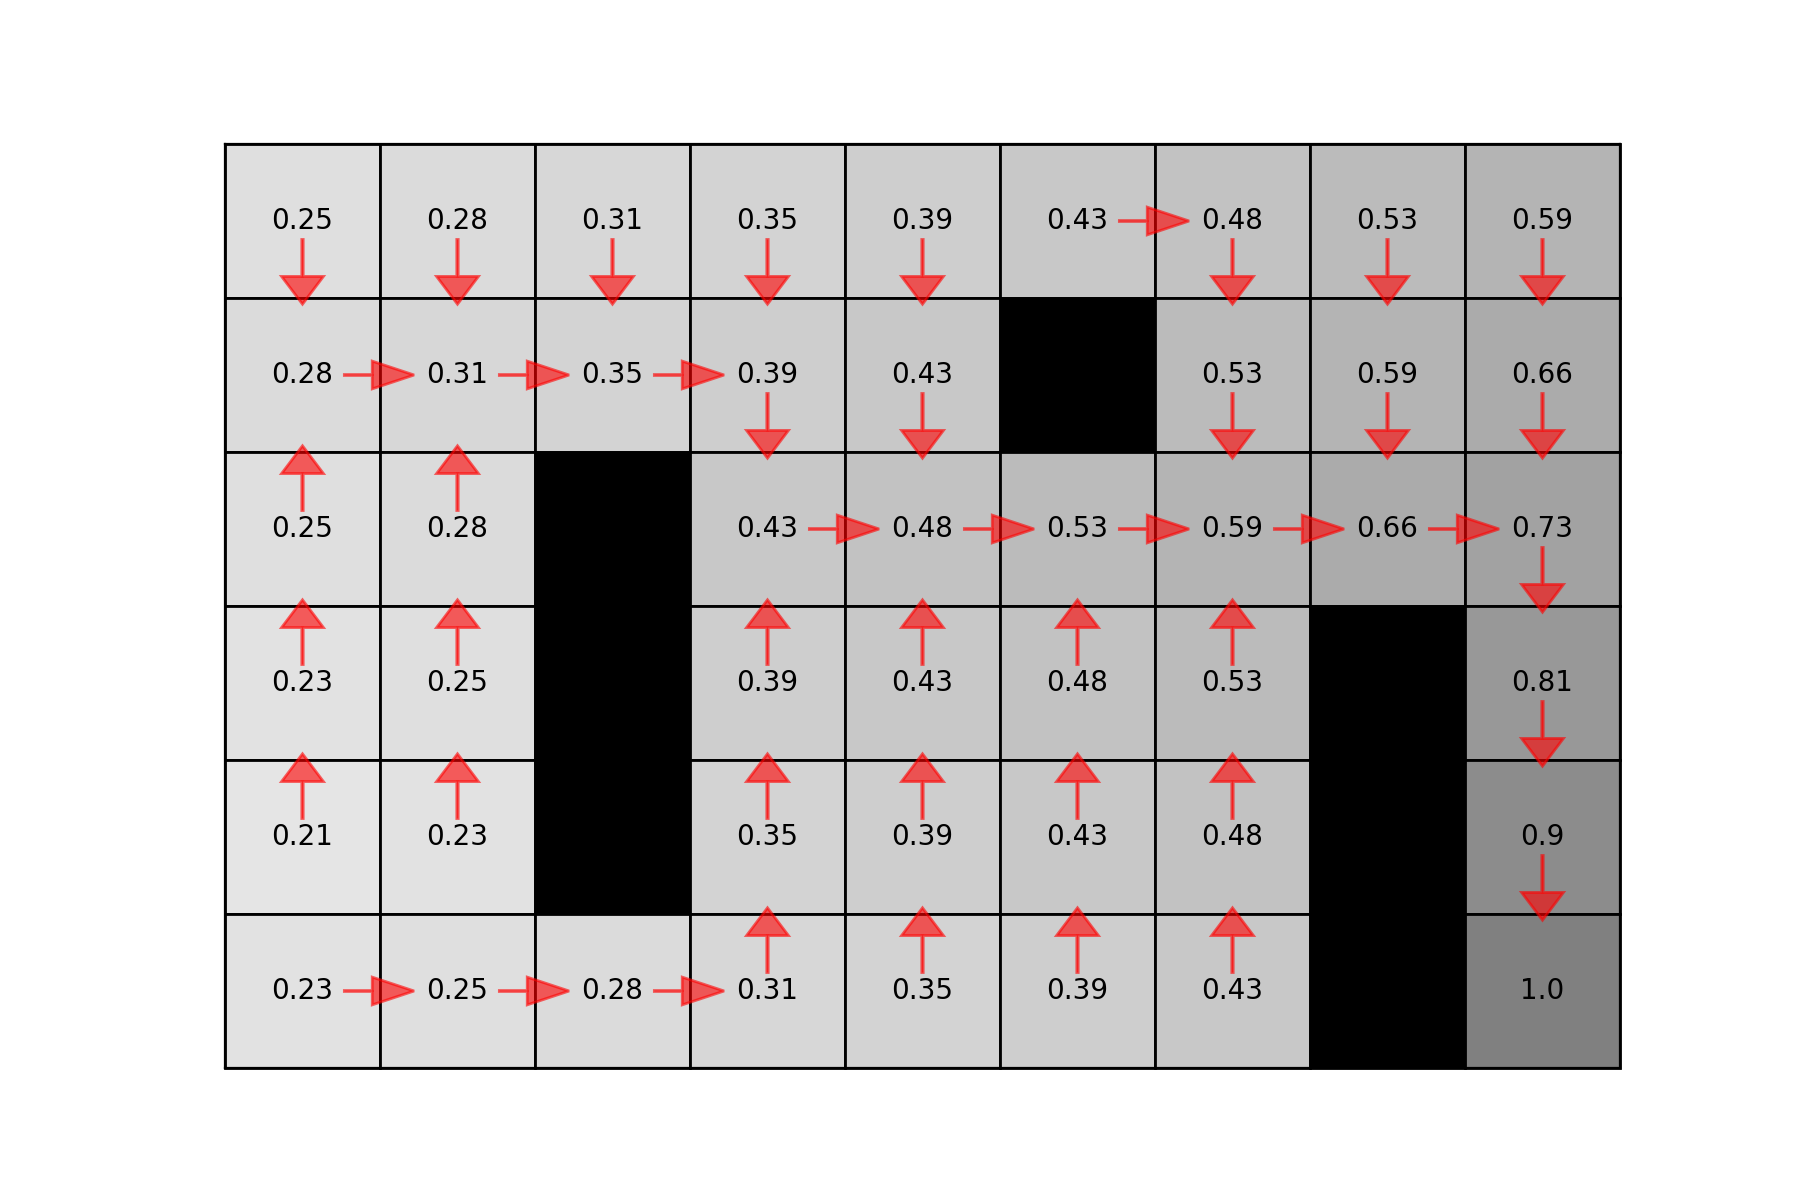

count:  17


In [16]:
%matplotlib notebook
# %run mdp.ipynb

# import import_ipynb
# import mdp
# import maze_plotter

#from ipynb.fs.defs.mdp import maze_mdp # Markov Decision Process
#from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution

walls = [14,15,16,31,45,46,47]
height = 6
width = 9
m = maze_mdp(width, height, walls=walls, terminal_states=[height*width-1]) # maze-like MDP definition

[V_list, policy_list] = VI_V(m, render=True)

### Value iteration with the *Q* function

The state-action value function $Q^{\pi}(s,a)$ defines the value of being in state $x$, taking action $u$ then following policy $\pi$. The Bellman Optimality Equation for $Q^*$ is:
    $$ Q^*(x,u) =  r(x,u) + \gamma \sum_{y} P(x,u,y) \max_{u'}Q^*(y,u'). $$ 

By taking inspiration from the VI_V(mdp) function given above, fill the blank (given with '//...') in the code below.
Run in with the cell given just after the VI_Q(mdp) function.


In [17]:
import numpy as np

def VI_Q(mdp, render=True): #Value Iteration based on the state-action value Q
    #Same as above, but we save all the computed values in the Q table 
    #(instead of saving only the optimal value of each state), so there is no need for a V_temp list
    Q = np.zeros((mdp.observation_space.size, mdp.action_space.size))
    pol = np.zeros((mdp.observation_space.size))
    quitt = False
    
    Q_list = [Q.copy()] 
    pol_list = [pol.copy()]
    Qmax = Q.max(axis=1)
        
    if render:
        mdp.new_render()
    
    count = 0
    while quitt==False:
        Qold = Q.copy()
        
        if render:
            mdp.render(Q, pol)
        
        for x in mdp.observation_space.states:
            for u in mdp.action_space.actions:
                if not x in mdp.terminal_states:
                    sum = 0
                    for y in mdp.observation_space.states:
                        sum = sum + mdp.P[x,u,y] * (max (Qold[y,:]))
                    Q[x,u] = mdp.r[x,u] + mdp.gamma * sum  # I changed here
                else:
                    Q[x,u] = mdp.r[x,u] 
                
        Qmax = Q.max(axis=1)
        pol =  np.argmax(Q, axis=1)
        
        Q_list.append(Q.copy())
        pol_list.append(pol)  
       
        count = count + 1
        if (np.linalg.norm(Q-Qold)) <= 0.01 :
            quitt = True
            print("count: ", count)
    
    if render:
        mdp.render(Q, pol)
        
    return [Q_list, pol_list]

<IPython.core.display.Javascript object>


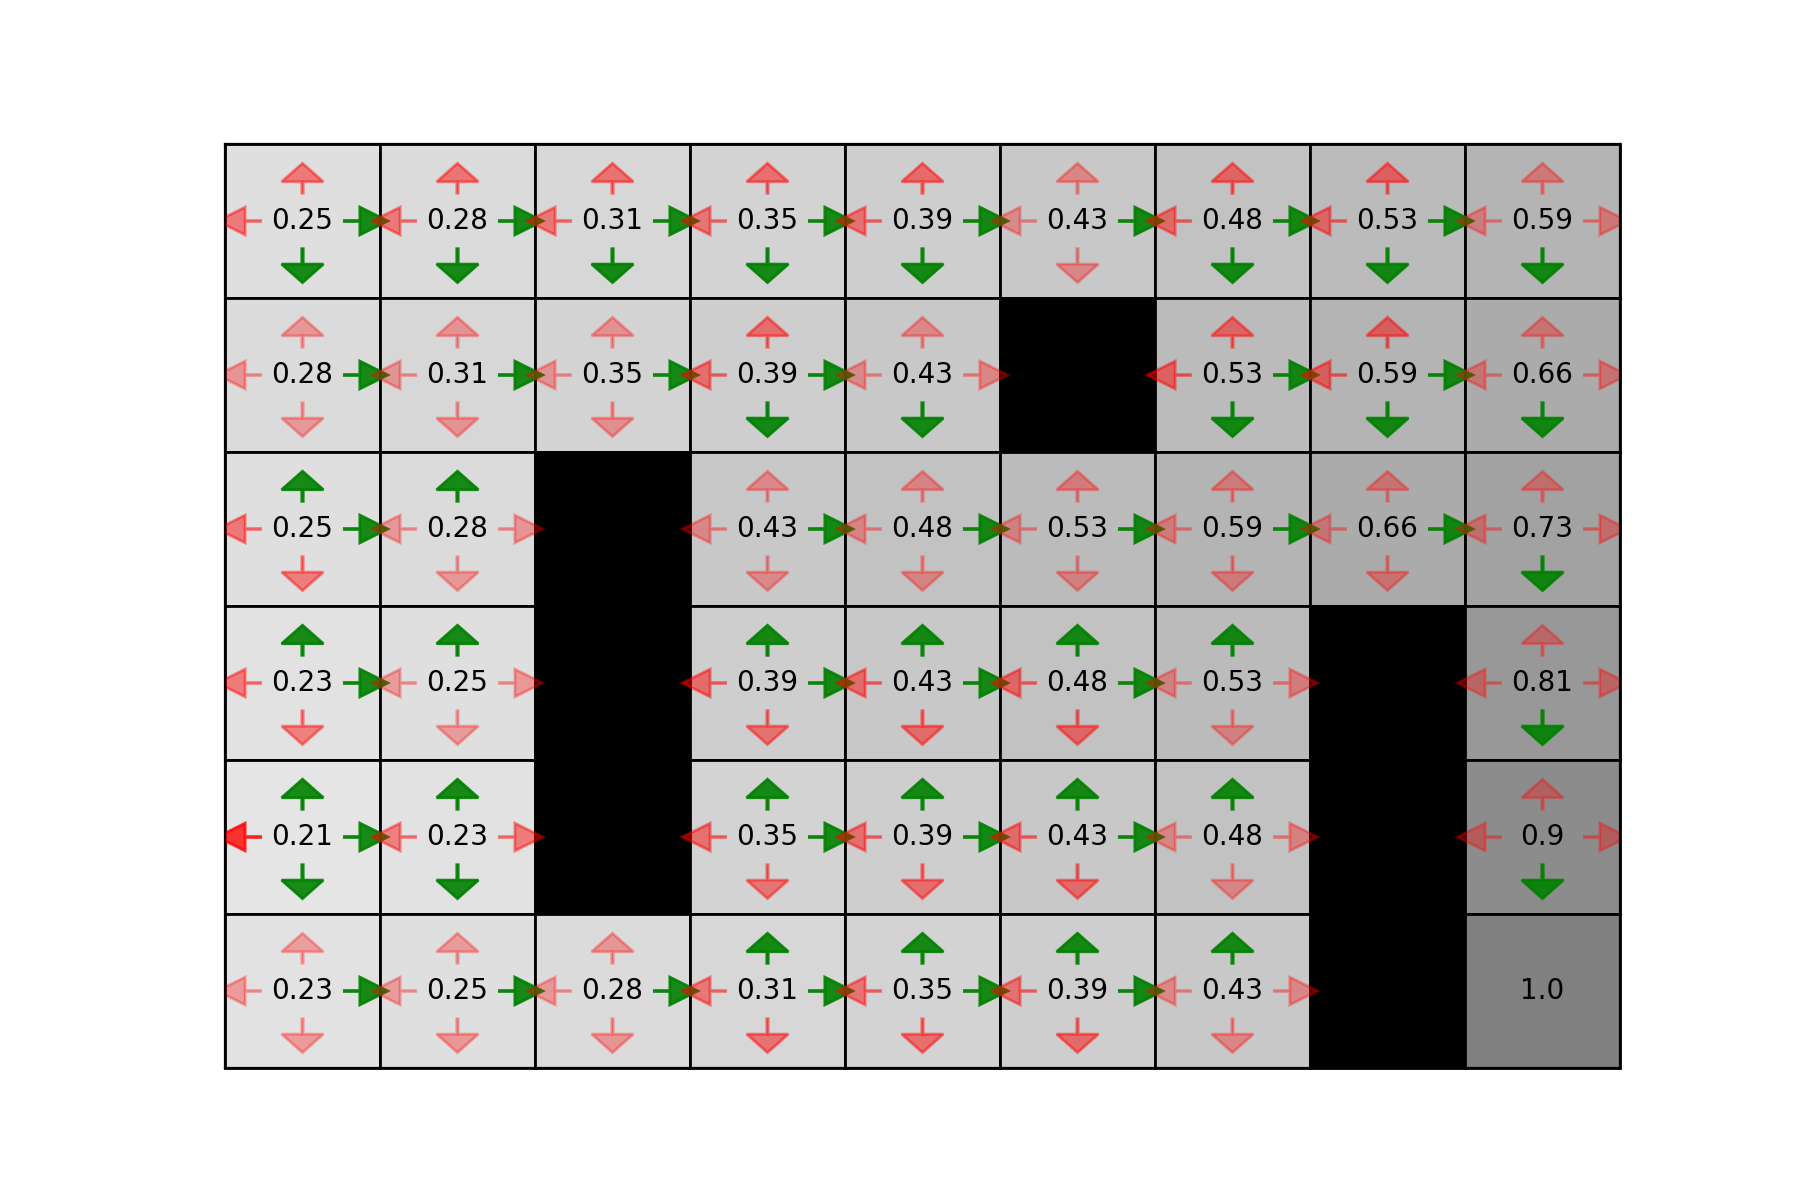

count:  18


In [18]:
"\\... run your code here"
[V_list, policy_list] = VI_Q(m, render=True)

## Policy Iteration

### Policy Iteration with the *Q* function

Given a MDP and a policy $\pi$, policy iteration goes through the following process: 
* Evaluation of the policy $\pi$: computes the state-action value $Q$ based on the policy $\pi$;
* Improvement of the policy $\pi$: computes the new best policy based on the state-action value $Q$.

This process is repeated until convergence is achieved (the policy cannot be improved anymore).

The evaluation process relies on the Bellman Expectation Equation for $Q$ with deterministic policy $\pi$: 
    $$Q^{\pi}(x,u) = r(x,u) + \gamma \sum_{y \in S}P(x,u,y)Q^{\pi}(y,\pi(y)).$$

The policy can then be updated as follows:
    $$\pi^{(t+1)}(x) = \arg\max_uQ^{\pi^{(t)}}(x,u).$$

The box below gives the code of policy iteration with the $Q$ function. Again, have a close look at the code.

* can you find the part where the policy is evaluated, and the part where it is updated? Why do we have to loop twice over states in the former?

In the cell given just after the PI_Q(mdp) function, by taking inspiration of the cell just above, write the code to run it and vizualize it.


In [19]:
# Policy comes first, then Value, then update Policy and so on
import numpy as np

def PI_Q(mdp, render=True): # policy iteration over the Q function
    Q = np.zeros((mdp.observation_space.size, mdp.action_space.size))
    pol = np.zeros(mdp.observation_space.size, dtype=np.int16)
    
    Q_list = [Q.copy()]
    policy_list = [pol.copy()]
    
    quitt = False
    
    if render:
        mdp.new_render()
    
    count = 0
    while quitt==False:
        Qold = Q.copy()
        if render:
            mdp.render(Q.max(axis=1),pol)
            
        # Step 1 : Policy Evaluation
        for x in mdp.observation_space.states:
            for u in mdp.action_space.actions:
                if x in mdp.terminal_states:
                    Q[x,u] = mdp.r[x,u]
                else :
                    sum = 0
                    for y in mdp.observation_space.states:
                        sum = sum + mdp.P[x,u,y] * Qold[y, pol[y]]
                    Q[x,u] = mdp.r[x,u] + mdp.gamma * sum
        
        # Step 2 : Policy Improvement
        pol =  np.argmax(Q, axis=1)         
        
        Q_list.append(Q.copy())
        policy_list.append(pol.copy())
        
        count = count + 1
        # Check the convergence
        if np.array_equal(Q_list[-1], Q_list[-2]):
            quitt = True
            print("count: ", count)
    
    if render:
            mdp.render(Q.max(axis=1),pol)
            
    return [Q_list, policy_list]

<IPython.core.display.Javascript object>


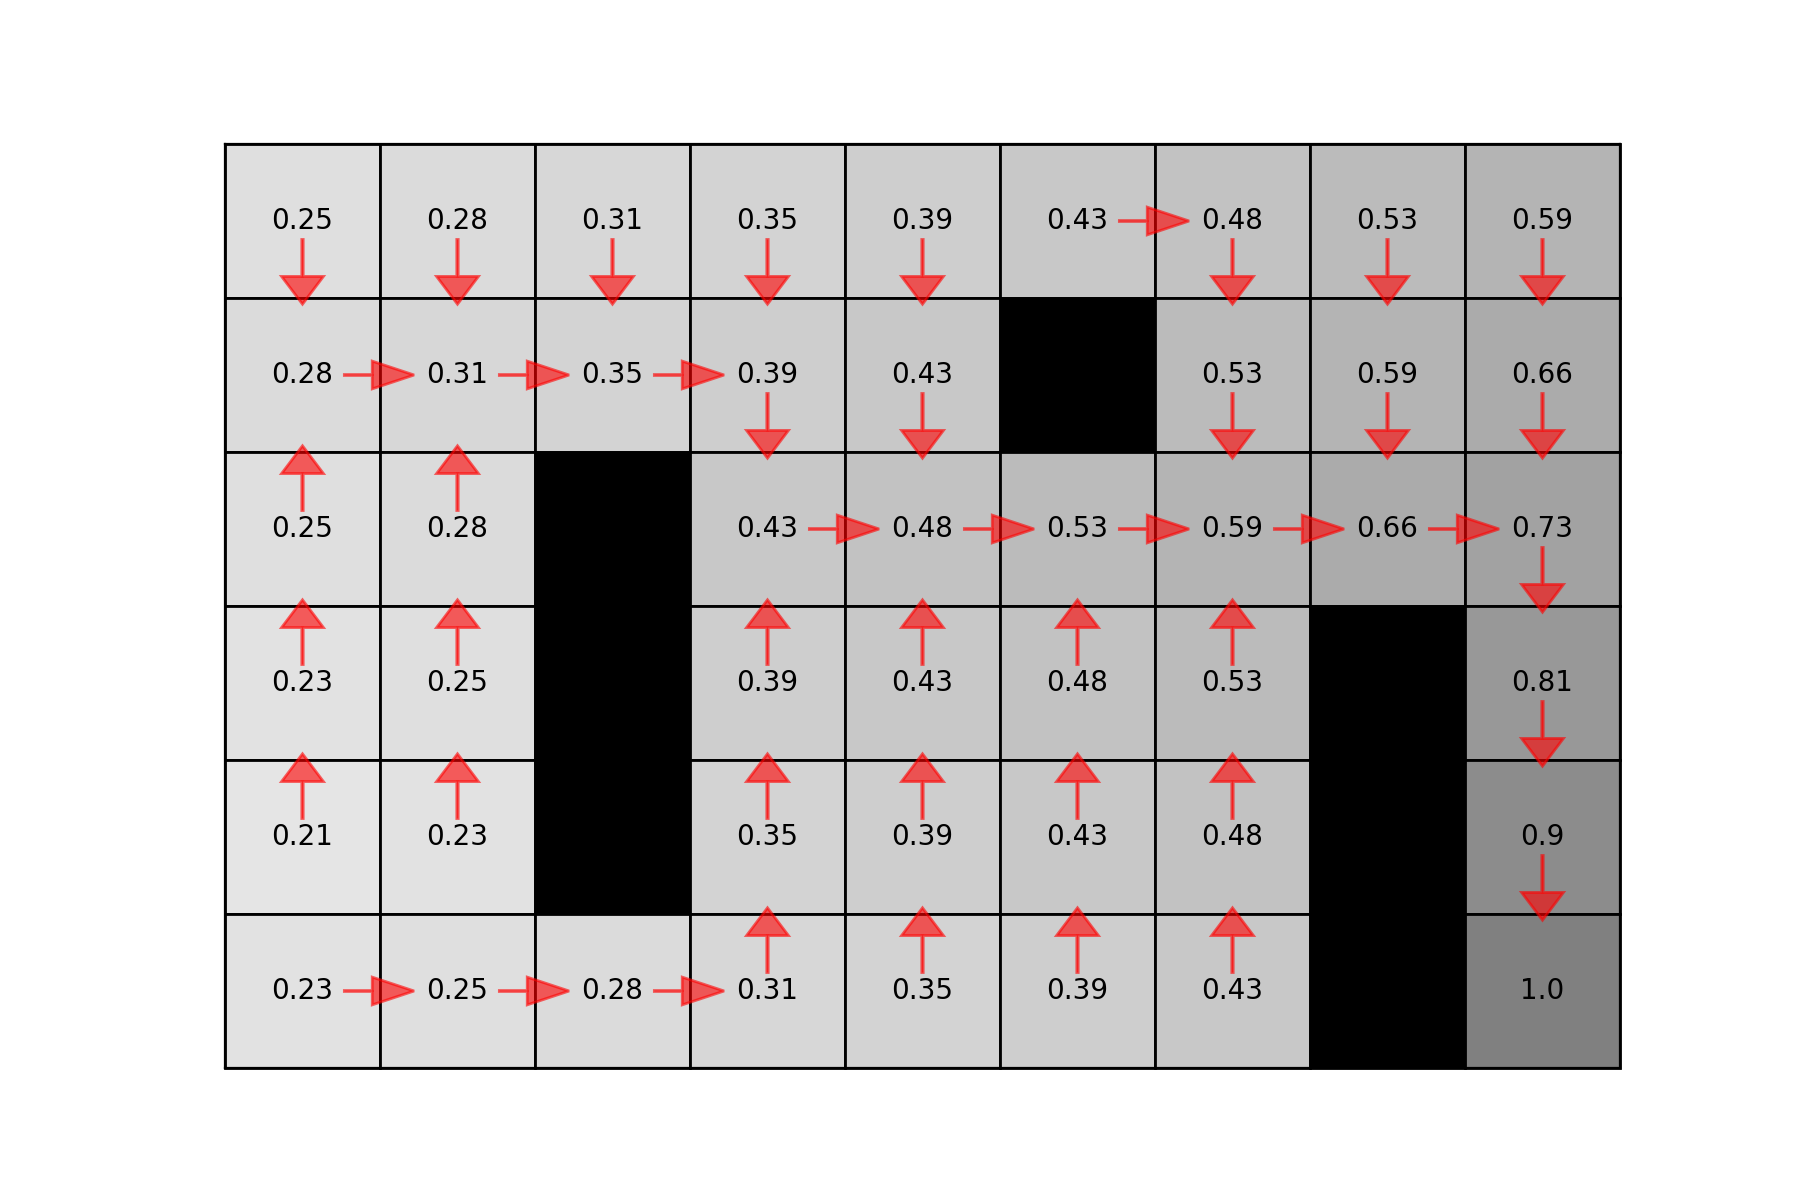

count:  18


In [20]:
"\\... run the above code here"
[V_list, policy_list] = PI_Q(m, render=True)

### Policy Iteration with the *V* function

By taking inspiration from the PI_Q(mdp) function given above, write a PI_V(mdp) function that implements policy iteration with the *V* function 

In [21]:
"\\ write the PI_V(mdp) function here"
# Policy comes first, then Value, then update Policy and so on

def PI_V(mdp, render=True): # policy iteration over the Q function
    V = np.zeros((mdp.observation_space.size))
    pol = np.zeros(mdp.observation_space.size, dtype=np.int16)
    
    V_list = [V.copy()]
    policy_list = [pol.copy()]
    
    quitt = False
    
    if render:
        mdp.new_render()
    
    count = 0
    while quitt==False:
        Vold = V.copy()
        if render:
            mdp.render(V, pol)
            
        # Step 1 : Policy Evaluation
        for x in mdp.observation_space.states:
            V_temp = []
            u = pol[x]
            if x in mdp.terminal_states:
                V[x] = mdp.r[x,u]
            else :
                sum = 0
                for y in mdp.observation_space.states:
                    sum = sum + mdp.P[x,u,y] * Vold[y]
                V[x] = mdp.r[x,u] + mdp.gamma * sum

            
        # Step 2 : Policy Improvement
        # Set the policy for this state as the action u that maximizes the state value of x
        for x in mdp.observation_space.states:
            V_temp = []
            for u in mdp.action_space.actions:
                if x in mdp.terminal_states:
                    V_temp.append(mdp.r[x,u])
                else :
                    sum = 0
                    for y in mdp.observation_space.states:
                        sum = sum + mdp.P[x,u,y] * V[y]
                    V_temp.append(mdp.r[x,u] + mdp.gamma * sum)

            pol[x] = np.argmax(V_temp)
         
        V_list.append(V.copy())
        policy_list.append(pol.copy())
        
        count = count + 1
        # Check the convergence
        if np.array_equal(V_list[-1], V_list[-2]):
            quitt = True
            print("count: ", count) 
    
    if render:
            mdp.render(V, pol)
        
    return [V_list, policy_list]

<IPython.core.display.Javascript object>


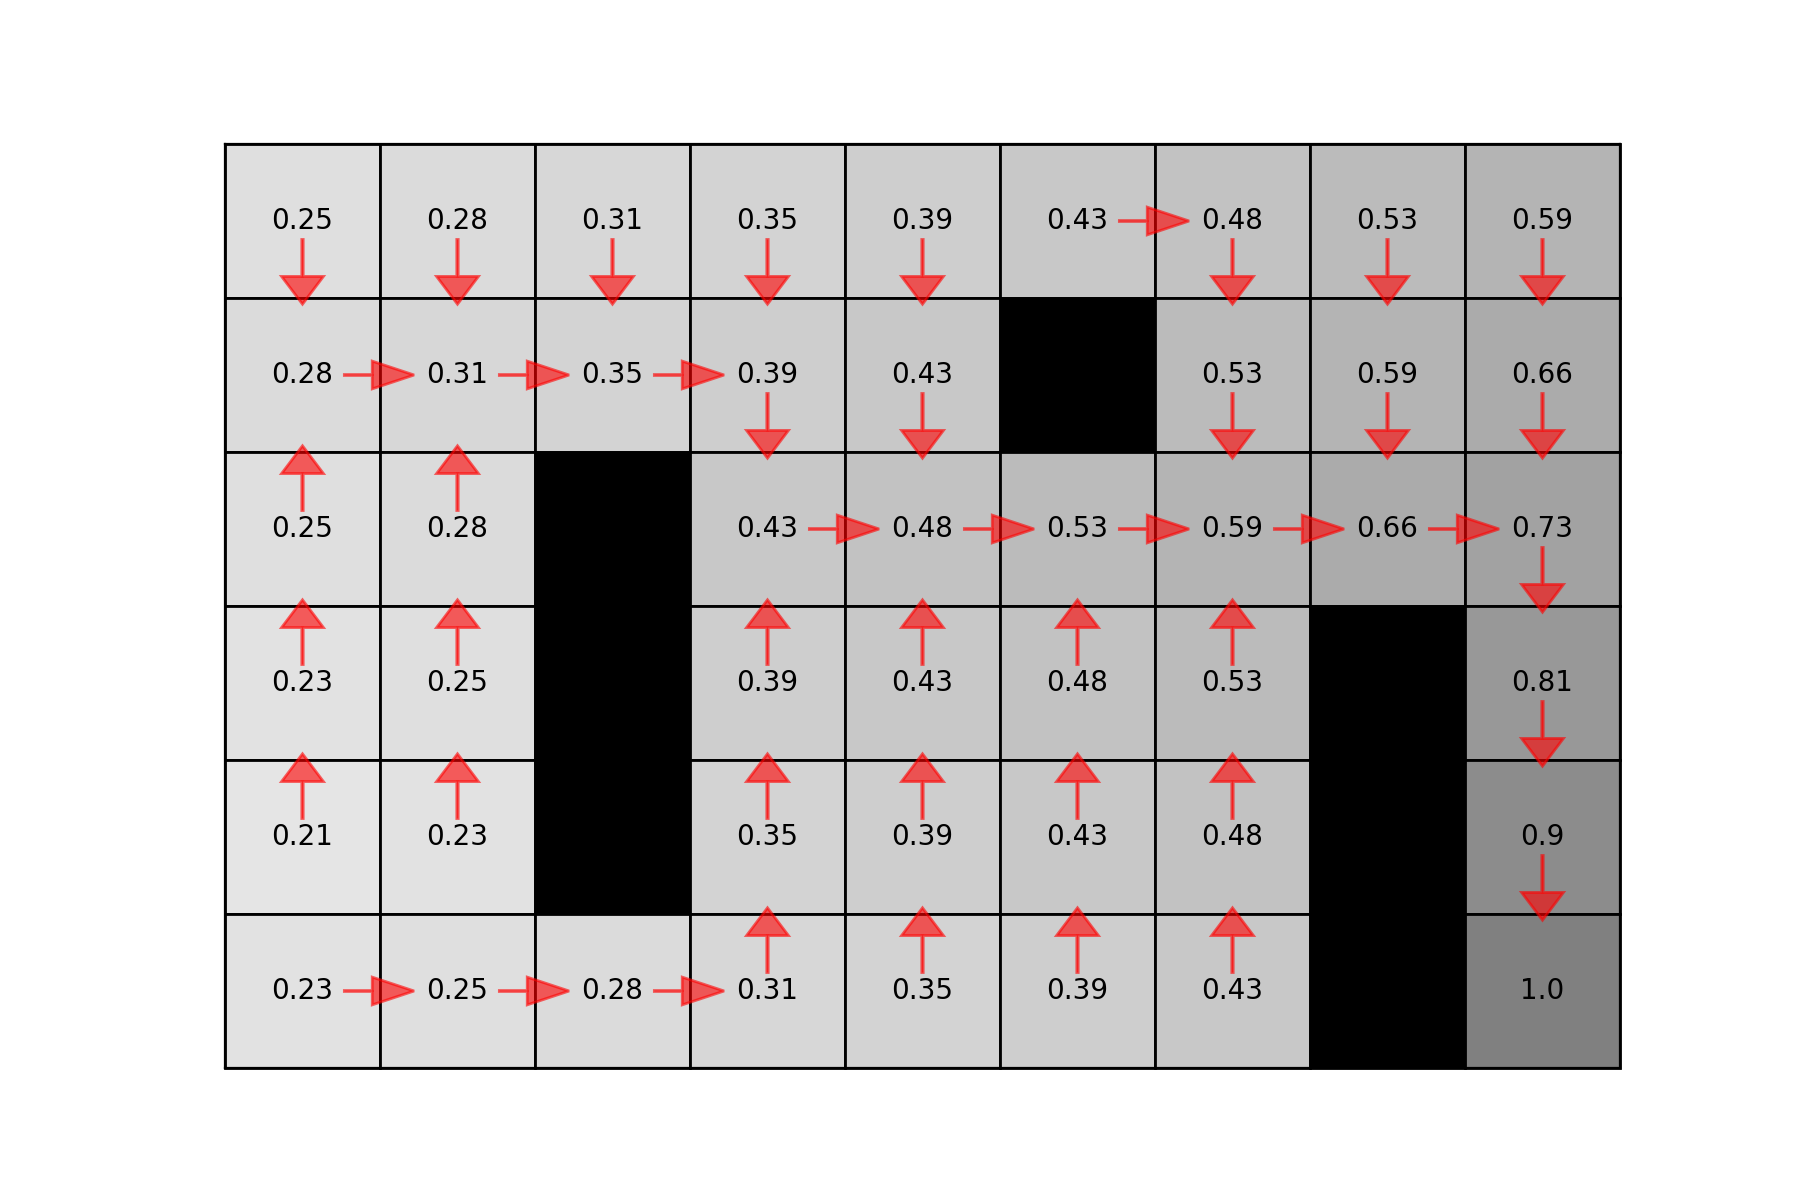

count:  17


In [22]:
"\\ run the PI_V(mdp) function here to visualize it"
[V_list, policy_list] = PI_V(m, render=True)

## Wrapping up

Which of all the above methods converges in fewer steps? To answer the question, add a step counter to the above codes, run them again and print the step counter in the end.

Discuss the relative computational efficiency of these methods.

### Open question

The [*Generalized Policy Iteration*](https://link.springer.com/content/pdf/10.1007/BF00933260.pdf) algorithm draws a continuum between value iteration and policy iteration. Try to implement it and parametrize it to obtain the value iteration regime, the policy iteration regime, and something intermediate.